## Generate data

In [22]:
from PIL import Image, ImageDraw
import random
import pandas as pd
import os
import shutil
from tqdm import tqdm
import keras

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.facecolor']='white'

In [23]:
# USE THIS FOR Tensorflow BACKEND ONLY
K.set_image_data_format('channels_last')

In [24]:
IMG_WIDTH = 64
IMG_HEIGHT = IMG_WIDTH
DOT_SIZE = 8

SAMPLE_COUNT = 6000
MAX_DOT_COUNT = 10

def create_dataset(folder, samples, is_test=False):
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

    csv_data = []
    for sample in tqdm(range(SAMPLE_COUNT)):
        dot_ct = random.randint(1, MAX_DOT_COUNT)
        image = Image.new("RGB", (IMG_WIDTH, IMG_HEIGHT), (255,255,255))
        draw = ImageDraw.Draw(image)

        for _ in range(dot_ct):
            x = random.randint(0, IMG_WIDTH - DOT_SIZE)
            y = random.randint(0, IMG_WIDTH - DOT_SIZE)
            draw.ellipse((x, y, x + DOT_SIZE, y + DOT_SIZE), fill="black") 

        del draw
        file_name = "%s/%s.png" % (folder, sample)
        image.save(file_name, "PNG")
        csv_data.append((sample, file_name, dot_ct))

    if is_test:
        df = pd.DataFrame(csv_data, columns=["id", "file", "count"])
        df.to_csv('%s/list.csv' % folder, index=False, columns=["id", "file"])
    else:
        df = pd.DataFrame(csv_data, columns=["id", "file", "count"])
        df.to_csv('%s/list.csv' % folder, index=False)


create_dataset("train", SAMPLE_COUNT, False)
create_dataset("test", SAMPLE_COUNT, False)

100%|██████████| 6000/6000 [00:02<00:00, 2763.03it/s]


In [25]:
from PIL import Image as pil_image
from keras import backend as K
import numpy as np

def load_img(path, grayscale=False, target_size=None, interpolation='bilinear'):
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            if interpolation not in _PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(
                        interpolation,
                        ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
            resample = _PIL_INTERPOLATION_METHODS[interpolation]
            img = img.resize(width_height_tuple, resample)
    return img

def img_to_array(img, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x

def array_to_img(x, data_format=None, scale=True):
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])

## Data loading & transform

In [30]:
df_trn = pd.read_csv('train/list.csv')
df_tst = pd.read_csv('test/list.csv')

In [31]:
y_trn_r = df_trn['count'].values
y_tst_r = df_tst['count'].values

In [32]:
x_trn = np.array(list(map(lambda x: img_to_array(load_img(x,grayscale=True)),df_trn['file'])))
x_tst = np.array(list(map(lambda x: img_to_array(load_img(x,grayscale=True)),df_tst['file'])))
x_trn /= 255
x_tst /= 255

## Model

In [33]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.models import Model, Sequential

input_shape = (IMG_WIDTH, IMG_HEIGHT, 1)

model = Sequential()
model.add(Conv2D(16, kernel_size=(4,4), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(4,4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 61, 61, 16)        272       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        8224      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                86544     
__________

In [34]:
model.compile(loss=keras.losses.mean_squared_error, optimizer='adam', 
              metrics=['accuracy', 'mean_absolute_error'])

history_r = model.fit(x_trn, y_trn_r, batch_size=256, epochs=256,
                      verbose=1, validation_data=(x_tst, y_tst_r))

Train on 6000 samples, validate on 6000 samples
Epoch 1/256
6000/6000 [==============================] - 1s 138us/step - loss: 13.2587 - acc: 0.1058 - mean_absolute_error: 2.9310 - val_loss: 5.0350 - val_acc: 0.1375 - val_mean_absolute_error: 1.9031
Epoch 2/256
6000/6000 [==============================] - 1s 104us/step - loss: 4.3090 - acc: 0.1990 - mean_absolute_error: 1.6208 - val_loss: 1.1362 - val_acc: 0.3768 - val_mean_absolute_error: 0.8126
Epoch 3/256
6000/6000 [==============================] - 1s 98us/step - loss: 3.3172 - acc: 0.2863 - mean_absolute_error: 1.3253 - val_loss: 0.7278 - val_acc: 0.4138 - val_mean_absolute_error: 0.6916
Epoch 4/256
6000/6000 [==============================] - 1s 101us/step - loss: 3.0748 - acc: 0.3117 - mean_absolute_error: 1.2735 - val_loss: 0.9490 - val_acc: 0.5277 - val_mean_absolute_error: 0.7058
Epoch 5/256
6000/6000 [==============================] - 1s 100us/step - loss: 2.9251 - acc: 0.3218 - mean_absolute_error: 1.2325 - val_loss: 0.8274

6000/6000 [==============================] - 1s 100us/step - loss: 2.2810 - acc: 0.4313 - mean_absolute_error: 1.0364 - val_loss: 0.7089 - val_acc: 0.5047 - val_mean_absolute_error: 0.6369
Epoch 42/256
6000/6000 [==============================] - 1s 100us/step - loss: 2.4733 - acc: 0.3912 - mean_absolute_error: 1.1037 - val_loss: 0.5837 - val_acc: 0.5752 - val_mean_absolute_error: 0.5536
Epoch 43/256
6000/6000 [==============================] - 1s 98us/step - loss: 2.1804 - acc: 0.4245 - mean_absolute_error: 1.0262 - val_loss: 0.2287 - val_acc: 0.8017 - val_mean_absolute_error: 0.3153
Epoch 44/256
6000/6000 [==============================] - 1s 99us/step - loss: 2.2753 - acc: 0.4152 - mean_absolute_error: 1.0478 - val_loss: 0.4037 - val_acc: 0.6778 - val_mean_absolute_error: 0.4381
Epoch 45/256
6000/6000 [==============================] - 1s 100us/step - loss: 2.3253 - acc: 0.4238 - mean_absolute_error: 1.0491 - val_loss: 0.3527 - val_acc: 0.7115 - val_mean_absolute_error: 0.4019
Epoch

Epoch 82/256
6000/6000 [==============================] - 1s 102us/step - loss: 1.7514 - acc: 0.4783 - mean_absolute_error: 0.8987 - val_loss: 0.2058 - val_acc: 0.8107 - val_mean_absolute_error: 0.2978
Epoch 83/256
6000/6000 [==============================] - 1s 98us/step - loss: 1.8306 - acc: 0.4990 - mean_absolute_error: 0.8971 - val_loss: 0.1703 - val_acc: 0.8395 - val_mean_absolute_error: 0.2770
Epoch 84/256
6000/6000 [==============================] - 1s 103us/step - loss: 1.8467 - acc: 0.4788 - mean_absolute_error: 0.9176 - val_loss: 0.4482 - val_acc: 0.6143 - val_mean_absolute_error: 0.5005
Epoch 85/256
6000/6000 [==============================] - 1s 102us/step - loss: 1.8053 - acc: 0.4875 - mean_absolute_error: 0.9021 - val_loss: 0.1426 - val_acc: 0.8740 - val_mean_absolute_error: 0.2747
Epoch 86/256
6000/6000 [==============================] - 1s 102us/step - loss: 1.7172 - acc: 0.4918 - mean_absolute_error: 0.8851 - val_loss: 0.1495 - val_acc: 0.8658 - val_mean_absolute_error

6000/6000 [==============================] - 1s 97us/step - loss: 1.4362 - acc: 0.5077 - mean_absolute_error: 0.8102 - val_loss: 0.2402 - val_acc: 0.7745 - val_mean_absolute_error: 0.3448
Epoch 123/256
6000/6000 [==============================] - 1s 95us/step - loss: 1.3964 - acc: 0.5223 - mean_absolute_error: 0.7932 - val_loss: 0.2905 - val_acc: 0.7293 - val_mean_absolute_error: 0.3891
Epoch 124/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.4485 - acc: 0.5242 - mean_absolute_error: 0.8050 - val_loss: 0.1540 - val_acc: 0.8645 - val_mean_absolute_error: 0.2805
Epoch 125/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.4326 - acc: 0.5028 - mean_absolute_error: 0.8165 - val_loss: 0.3822 - val_acc: 0.6472 - val_mean_absolute_error: 0.4693
Epoch 126/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.4603 - acc: 0.5038 - mean_absolute_error: 0.8153 - val_loss: 0.1816 - val_acc: 0.8337 - val_mean_absolute_error: 0.2913
Epoc

Epoch 163/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.2287 - acc: 0.5362 - mean_absolute_error: 0.7366 - val_loss: 0.1511 - val_acc: 0.8360 - val_mean_absolute_error: 0.2886
Epoch 164/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.2340 - acc: 0.5315 - mean_absolute_error: 0.7437 - val_loss: 0.1776 - val_acc: 0.8142 - val_mean_absolute_error: 0.3027
Epoch 165/256
6000/6000 [==============================] - 1s 95us/step - loss: 1.2057 - acc: 0.5482 - mean_absolute_error: 0.7284 - val_loss: 0.1629 - val_acc: 0.8527 - val_mean_absolute_error: 0.2873
Epoch 166/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.2704 - acc: 0.5268 - mean_absolute_error: 0.7554 - val_loss: 0.1503 - val_acc: 0.8430 - val_mean_absolute_error: 0.2847
Epoch 167/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.2035 - acc: 0.5280 - mean_absolute_error: 0.7434 - val_loss: 0.1868 - val_acc: 0.8177 - val_mean_absolute_erro

6000/6000 [==============================] - 1s 99us/step - loss: 1.1138 - acc: 0.5515 - mean_absolute_error: 0.7142 - val_loss: 0.2083 - val_acc: 0.7870 - val_mean_absolute_error: 0.3358
Epoch 204/256
6000/6000 [==============================] - 1s 99us/step - loss: 1.1561 - acc: 0.5540 - mean_absolute_error: 0.7251 - val_loss: 0.2017 - val_acc: 0.8113 - val_mean_absolute_error: 0.3232
Epoch 205/256
6000/6000 [==============================] - 1s 100us/step - loss: 1.1230 - acc: 0.5565 - mean_absolute_error: 0.7159 - val_loss: 0.1865 - val_acc: 0.8130 - val_mean_absolute_error: 0.3140
Epoch 206/256
6000/6000 [==============================] - 1s 100us/step - loss: 1.0645 - acc: 0.5727 - mean_absolute_error: 0.6905 - val_loss: 0.2686 - val_acc: 0.7470 - val_mean_absolute_error: 0.3896
Epoch 207/256
6000/6000 [==============================] - 1s 100us/step - loss: 1.1277 - acc: 0.5505 - mean_absolute_error: 0.7202 - val_loss: 0.1488 - val_acc: 0.8407 - val_mean_absolute_error: 0.2885
E

6000/6000 [==============================] - 1s 94us/step - loss: 1.0310 - acc: 0.5950 - mean_absolute_error: 0.6742 - val_loss: 0.1589 - val_acc: 0.7952 - val_mean_absolute_error: 0.2988
Epoch 244/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.0187 - acc: 0.5817 - mean_absolute_error: 0.6777 - val_loss: 0.2057 - val_acc: 0.7332 - val_mean_absolute_error: 0.3317
Epoch 245/256
6000/6000 [==============================] - 1s 93us/step - loss: 1.0605 - acc: 0.5922 - mean_absolute_error: 0.6855 - val_loss: 0.2967 - val_acc: 0.6350 - val_mean_absolute_error: 0.4227
Epoch 246/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.1018 - acc: 0.5853 - mean_absolute_error: 0.6990 - val_loss: 0.2606 - val_acc: 0.6813 - val_mean_absolute_error: 0.3865
Epoch 247/256
6000/6000 [==============================] - 1s 94us/step - loss: 1.0939 - acc: 0.5843 - mean_absolute_error: 0.6957 - val_loss: 0.1888 - val_acc: 0.7667 - val_mean_absolute_error: 0.3269
Epoc

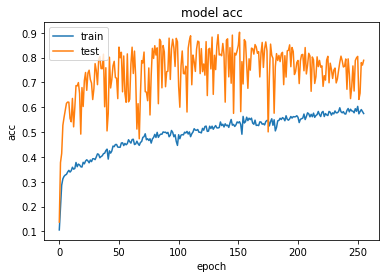

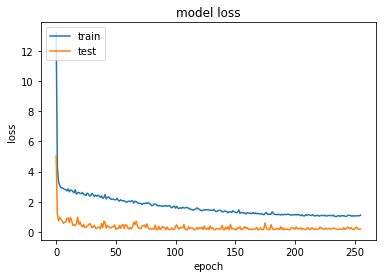

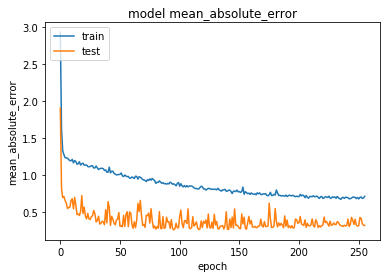

In [36]:
my_plots = ['acc', 'loss', 'mean_absolute_error']
for plot in my_plots:
    plt.plot(history_r.history[plot])
    plt.plot(history_r.history['val_' + plot])
    plt.title('model ' + plot)
    plt.ylabel(plot)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Check result visually

In [38]:
tst_img = list(map(lambda x: load_img(x,grayscale=True),df_tst['file']))
tst_prd = model.predict(x_tst, verbose=0)

Prediction:  [7.3911114] Truth: 7


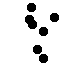

In [51]:
answer_index = 0
print("Prediction: ", tst_prd[answer_index], "Truth:", y_tst_r[answer_index])
tst_img[answer_index]

## The same algo, just to compare keras backends 

In [8]:
model.compile(loss=keras.losses.mean_squared_error, optimizer='adam', 
              metrics=['accuracy', 'mean_absolute_error'])

history_r = model.fit(x_trn, y_trn_r, batch_size=512, epochs=256,
                      verbose=1, validation_data=(x_tst, y_tst_r))

Train on 1000 samples, validate on 1000 samples
Epoch 1/256
1000/1000 [==============================] - 0s - loss: 31.6386 - acc: 0.0450 - mean_absolute_error: 3.4819 - val_loss: 10.5467 - val_acc: 0.1290 - val_mean_absolute_error: 2.6778
Epoch 2/256
1000/1000 [==============================] - 0s - loss: 11.7132 - acc: 0.0990 - mean_absolute_error: 3.0000 - val_loss: 11.9568 - val_acc: 0.1130 - val_mean_absolute_error: 2.8523
Epoch 3/256
1000/1000 [==============================] - 0s - loss: 12.1612 - acc: 0.1040 - mean_absolute_error: 2.5409 - val_loss: 6.4169 - val_acc: 0.1190 - val_mean_absolute_error: 2.1853
Epoch 4/256
1000/1000 [==============================] - 0s - loss: 7.8808 - acc: 0.1050 - mean_absolute_error: 2.4097 - val_loss: 8.1798 - val_acc: 0.0910 - val_mean_absolute_error: 2.3764
Epoch 5/256
1000/1000 [==============================] - 0s - loss: 9.1968 - acc: 0.1080 - mean_absolute_error: 2.4524 - val_loss: 7.3320 - val_acc: 0.0980 - val_mean_absolute_error: 2.24

1000/1000 [==============================] - 0s - loss: 1.5311 - acc: 0.4320 - mean_absolute_error: 0.8694 - val_loss: 0.4984 - val_acc: 0.6550 - val_mean_absolute_error: 0.4925
Epoch 86/256
1000/1000 [==============================] - 0s - loss: 1.3519 - acc: 0.4460 - mean_absolute_error: 0.8458 - val_loss: 0.4132 - val_acc: 0.6410 - val_mean_absolute_error: 0.4680
Epoch 87/256
1000/1000 [==============================] - 0s - loss: 1.2297 - acc: 0.4410 - mean_absolute_error: 0.8058 - val_loss: 0.4451 - val_acc: 0.6570 - val_mean_absolute_error: 0.4726
Epoch 88/256
1000/1000 [==============================] - 0s - loss: 1.3147 - acc: 0.4410 - mean_absolute_error: 0.8303 - val_loss: 0.5201 - val_acc: 0.6470 - val_mean_absolute_error: 0.5010
Epoch 89/256
1000/1000 [==============================] - 0s - loss: 1.3204 - acc: 0.4510 - mean_absolute_error: 0.8291 - val_loss: 0.3992 - val_acc: 0.6300 - val_mean_absolute_error: 0.4701
Epoch 90/256
1000/1000 [==============================] - 

1000/1000 [==============================] - 0s - loss: 1.2775 - acc: 0.4900 - mean_absolute_error: 0.7831 - val_loss: 0.3524 - val_acc: 0.7260 - val_mean_absolute_error: 0.4094
Epoch 170/256
1000/1000 [==============================] - 0s - loss: 1.2523 - acc: 0.4390 - mean_absolute_error: 0.8045 - val_loss: 0.3145 - val_acc: 0.7310 - val_mean_absolute_error: 0.3979
Epoch 171/256
1000/1000 [==============================] - 0s - loss: 1.2202 - acc: 0.4670 - mean_absolute_error: 0.7822 - val_loss: 0.3218 - val_acc: 0.7310 - val_mean_absolute_error: 0.3995
Epoch 172/256
1000/1000 [==============================] - 0s - loss: 1.1455 - acc: 0.4760 - mean_absolute_error: 0.7645 - val_loss: 0.3647 - val_acc: 0.7190 - val_mean_absolute_error: 0.4146
Epoch 173/256
1000/1000 [==============================] - 0s - loss: 1.1867 - acc: 0.4940 - mean_absolute_error: 0.7701 - val_loss: 0.3283 - val_acc: 0.7310 - val_mean_absolute_error: 0.4005
Epoch 174/256
1000/1000 [=============================

1000/1000 [==============================] - 0s - loss: 1.1731 - acc: 0.4970 - mean_absolute_error: 0.7668 - val_loss: 0.2687 - val_acc: 0.7590 - val_mean_absolute_error: 0.3606
Epoch 254/256
1000/1000 [==============================] - 0s - loss: 1.0980 - acc: 0.4980 - mean_absolute_error: 0.7424 - val_loss: 0.2633 - val_acc: 0.7570 - val_mean_absolute_error: 0.3584
Epoch 255/256
1000/1000 [==============================] - 0s - loss: 1.0234 - acc: 0.5120 - mean_absolute_error: 0.7133 - val_loss: 0.2715 - val_acc: 0.7660 - val_mean_absolute_error: 0.3600
Epoch 256/256
1000/1000 [==============================] - 0s - loss: 1.1337 - acc: 0.4890 - mean_absolute_error: 0.7489 - val_loss: 0.3306 - val_acc: 0.7440 - val_mean_absolute_error: 0.3896


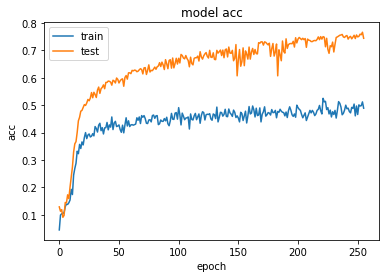

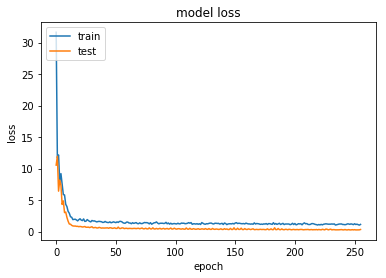

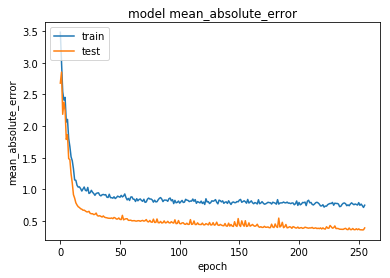

In [9]:
my_plots = ['acc', 'loss', 'mean_absolute_error']
for plot in my_plots:
    plt.plot(history_r.history[plot])
    plt.plot(history_r.history['val_' + plot])
    plt.title('model ' + plot)
    plt.ylabel(plot)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()